<a href="https://colab.research.google.com/github/MichalSlowakiewicz/Machine-Learning/blob/master/Homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt


# reading MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

# mean and std of dataset
mean_dataset = trainset.data.numpy().mean()/255.0
std_dataset = trainset.data.numpy().std()/255.0

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((mean_dataset), (std_dataset))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()

        # Define all layers explicitly
        self.linear1 = torch.nn.Linear(1*28*28, 1024)  # First linear layer
        self.linear2 = torch.nn.Linear(1024, 2048)     # Second linear layer
        self.linear3 = torch.nn.Linear(2048, 256)      # Third linear layer
        self.linear4 = torch.nn.Linear(256, 10)        # Final linear layer (no activation)

        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # Input shape: (B, 1, 28, 28)
        x = self.flatten(x)    # Shape: (B, 784)

        # Pass through all layers with ReLU activation
        x = self.relu(self.linear1(x))  # Shape: (B, 1024)
        x = self.relu(self.linear2(x))  # Shape: (B, 2048)
        x = self.relu(self.linear3(x))  # Shape: (B, 256)
        x = self.linear4(x)             # Shape: (B, 10) - no activation

        x = self.dropout(x)
        return x

In [13]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.299626111984253
epoch: 0 batch: 1 current batch loss: 2.0523269176483154
epoch: 0 batch: 2 current batch loss: 1.5940773487091064
epoch: 0 batch: 3 current batch loss: 1.141068458557129
epoch: 0 batch: 4 current batch loss: 0.8912779092788696
epoch: 0 batch: 5 current batch loss: 1.212377905845642
epoch: 0 batch: 6 current batch loss: 1.1143758296966553
epoch: 0 batch: 7 current batch loss: 1.1154881715774536
epoch: 0 batch: 8 current batch loss: 0.9349519610404968
epoch: 0 batch: 9 current batch loss: 0.8819080591201782
epoch: 0 batch: 10 current batch loss: 0.7684583067893982
epoch: 0 batch: 11 current batch loss: 0.5703754425048828
epoch: 0 batch: 12 current batch loss: 0.6940584182739258
epoch: 0 batch: 13 current batch loss: 0.6753333806991577
epoch: 0 batch: 14 current batch loss: 0.6168466806411743
epoch: 0 batch: 15 current batch loss: 0.5637708306312561
epoch: 0 batch: 16 current batch loss: 0.5133634209632874
epoch: 0 ba

In [14]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9806


Step 0, Loss: 12.9198, Confidence: [0.0, 0.0, 0.49, 0.01, 0.0, 1.0, 0.28, 0.93, 0.0, 0.0]
Step 9, Loss: 4.2591, Confidence: [0.0, 0.02, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 0.0, 0.01]
Step 50, Loss: 0.0000, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 100, Loss: 0.0000, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 150, Loss: 0.0000, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 200, Loss: 0.0000, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Step 250, Loss: 0.0000, Confidence: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


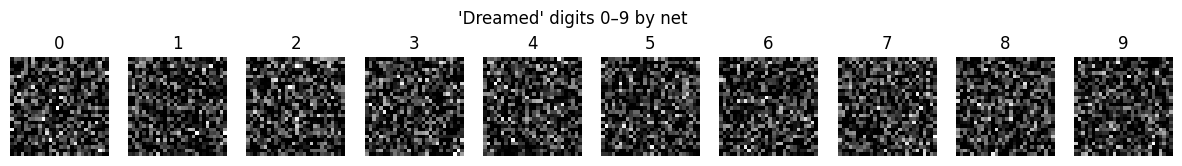

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# freezeing weights
net.eval()
for param in net.parameters():
    param.requires_grad = False

# gaussian noise as input
dreamed_inputs = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)

# i-th image -> i-th number
target_classes = torch.arange(10, device=device)

# optimizer for input
optimizer = torch.optim.Adam([dreamed_inputs], lr=0.01)

# normalizing dataset
mean_tensor = torch.tensor(mean_dataset, device=device)
std_tensor = torch.tensor(std_dataset, device=device)

# optimalization
for step in range(300):
    optimizer.zero_grad()

    # normalizing input
    normalized_inputs = (dreamed_inputs - mean_tensor) / std_tensor

    logits = net(normalized_inputs)
    loss = F.cross_entropy(logits, target_classes)

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 999:
        with torch.no_grad():
            probs = F.softmax(logits, dim=1)
            max_probs = probs.gather(1, target_classes.view(-1,1))
            print(f"Step {step}, Loss: {loss.item():.4f}, Confidence: {[round(p.item(), 2) for p in max_probs]}")

# inversing normalization for vizualization
dreamed_images_vis = dreamed_inputs.detach().cpu().clone()
dreamed_images_vis = dreamed_images_vis * std_dataset + mean_dataset
dreamed_images_vis = dreamed_images_vis.clamp(0, 1)

# vizualization
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axs[i].imshow(dreamed_images_vis[i][0], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))
plt.suptitle("'Dreamed' digits 0–9 by net")
plt.show()


Step 0, Mean Target Prob: 0.0000
Step 50, Mean Target Prob: 0.5000
Step 100, Mean Target Prob: 0.5000
Step 150, Mean Target Prob: 0.5000
Step 200, Mean Target Prob: 0.5000
Step 250, Mean Target Prob: 0.5000
Step 299, Mean Target Prob: 0.5000


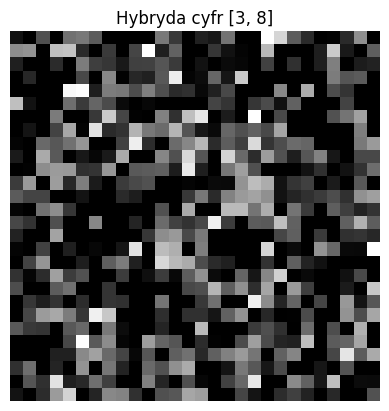

In [18]:
# Wybieramy klasy docelowe (np. 3 i 8)
target_classes = [3, 8]

# Inicjalizacja pojedynczego obrazu
hybrid_input = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

optimizer = torch.optim.Adam([hybrid_input], lr=0.1)

for step in range(300):
    optimizer.zero_grad()

    normalized_input = (hybrid_input - mean_tensor) / std_tensor
    logits = net(normalized_input)
    probs = F.softmax(logits, dim=1)

    # Maksymalizujemy średnią prawdopodobieństw klas docelowych
    target_probs = probs[0, target_classes]
    loss = -target_probs.mean()

    loss.backward()
    optimizer.step()

    if step % 50 == 0 or step == 299:
        print(f"Step {step}, Mean Target Prob: {target_probs.mean().item():.4f}")

# Denormalizacja i wizualizacja
hybrid_image_vis = hybrid_input.detach().cpu().clone()
hybrid_image_vis = hybrid_image_vis * std_dataset + mean_dataset
hybrid_image_vis = hybrid_image_vis.clamp(0, 1)

plt.imshow(hybrid_image_vis[0, 0], cmap='gray')
plt.axis('off')
plt.title(f"Hybryda cyfr {target_classes}")
plt.show()


In [25]:
import torch.nn.functional as F

l2_coeffs = [0.001, 0.01, 0.1, 1.0, 10.0]
dreamed_images_by_lambda = []

for lambda_l2 in l2_coeffs:
    print(f"\n=== Generowanie z L2 lambda = {lambda_l2} ===")

    dreamed_input = torch.randn((10, 1, 28, 28), device=device, requires_grad=True)
    targets = torch.arange(10, device=device)  # cyfry od 0 do 9

    optimizer = torch.optim.Adam([dreamed_input], lr=0.1)

    for step in range(300):
        optimizer.zero_grad()

        # Normalizacja wejścia
        normalized_input = (dreamed_input - mean_tensor) / std_tensor

        # Przejście przez sieć
        logits = net(normalized_input)
        loss_cls = F.cross_entropy(logits, targets)

        # Kara L2
        loss_l2 = dreamed_input.pow(2).mean()

        # Całkowita strata
        loss = loss_cls + lambda_l2 * loss_l2

        loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == 299:
            with torch.no_grad():
                preds = logits.argmax(dim=1)
                acc = (preds == targets).float().mean().item()
                print(f"Step {step}, Loss: {loss.item():.4f}, Accuracy: {acc:.2f}")

    # Denormalizacja do wizualizacji
    final_images = dreamed_input.detach().cpu().clone()
    final_images = final_images * std_dataset + mean_dataset
    final_images = final_images.clamp(0, 1)
    dreamed_images_by_lambda.append(final_images)



=== Generowanie z L2 lambda = 0.001 ===
Step 0, Loss: 16.3517, Accuracy: 0.10
Step 100, Loss: 0.0012, Accuracy: 1.00
Step 200, Loss: 0.0012, Accuracy: 1.00
Step 299, Loss: 0.0012, Accuracy: 1.00

=== Generowanie z L2 lambda = 0.01 ===
Step 0, Loss: 17.6907, Accuracy: 0.00
Step 100, Loss: 0.0135, Accuracy: 1.00
Step 200, Loss: 0.0130, Accuracy: 1.00
Step 299, Loss: 0.0124, Accuracy: 1.00

=== Generowanie z L2 lambda = 0.1 ===
Step 0, Loss: 17.3999, Accuracy: 0.00
Step 100, Loss: 0.1140, Accuracy: 1.00
Step 200, Loss: 0.0897, Accuracy: 1.00
Step 299, Loss: 0.0698, Accuracy: 1.00

=== Generowanie z L2 lambda = 1.0 ===
Step 0, Loss: 17.5968, Accuracy: 0.00
Step 100, Loss: 0.4534, Accuracy: 1.00
Step 200, Loss: 0.1429, Accuracy: 1.00
Step 299, Loss: 0.0478, Accuracy: 1.00

=== Generowanie z L2 lambda = 10.0 ===
Step 0, Loss: 24.9177, Accuracy: 0.20
Step 100, Loss: 0.0467, Accuracy: 1.00
Step 200, Loss: 0.0138, Accuracy: 1.00
Step 299, Loss: 0.0136, Accuracy: 1.00
